In [97]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [98]:
def compute_values(name,nmodels):
    total = torch.load(name)
    train_flat, valid_flat = total[:nmodels,:], total[nmodels:,:]
    train_diff = train_flat[0,:]-train_flat[1:,:].mean(dim=0)
    valid_diff = valid_flat[0,:]-valid_flat[1:,:].mean(dim=0)
    return train_diff, valid_diff

In [99]:
train70M, val70M = compute_values("pythia-70M-deduped Perturbation attack (#new models=10, noise_var=0.01, bs=8, nbatches=500, length=50).pt", 11)
train160M, val160M = compute_values("pythia-160M-deduped Perturbation attack (#new models=10, noise_var=0.01, bs=8, nbatches=500, length=50).pt", 11)
train410M, val410M = compute_values("pythia-410M-deduped Perturbation attack (#new models=10, noise_var=0.005, bs=8, nbatches=500, length=50).pt", 11)
train1B, val1B   = compute_values("pythia-1B-deduped Perturbation attack (#new models=10, noise_var=0.01, bs=8, nbatches=500, length=50).pt", 11)
train1B4, val1B4 = compute_values("pythia-1.4B-deduped Perturbation attack (#new models=10, noise_var=0.005, bs=8, nbatches=500, length=50).pt", 11)
train2B8, val2B8 = compute_values("pythia-2.8B-deduped Perturbation attack (#new models=10, noise_var=0.005, bs=8, nbatches=500, length=50).pt", 11)
#train6B9, val6B9 = compute_values("pythia-6.9B-deduped Perturbation attack (#new models=10, noise_var=0.01, bs=8, nbatches=500, length=50).pt")

In [100]:
def compute_fpr_tpr_thresholds(valuestraining, valuesvalidation, st, end):
    not_nan = torch.logical_not(torch.logical_or( torch.isnan(valuestraining),torch.isnan(valuesvalidation)))
    valuestraining = valuestraining[not_nan]
    valuesvalidation = valuesvalidation[not_nan]

    y_scores =  torch.cat((valuestraining, valuesvalidation))
    y_scores = y_scores-st
    y_scores = y_scores/end
    y_true   = [1 for _ in range(len(valuestraining))] + [0 for _ in range(len(valuesvalidation))]

    return roc_curve(y_true,y_scores)

tensor(-327.7820) tensor(327.6828)


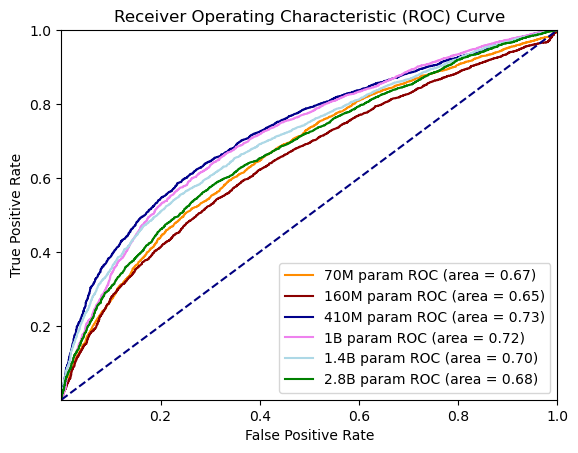

In [101]:

from sklearn.metrics import roc_curve, auc
train_data = [(train70M, val70M), (train160M, val160M), (train410M, val410M), (train1B, val1B), (train1B4, val1B4), (train2B8, val2B8)]#, (train6B9, val6B9)]


st = min([ min(min(t),min(u)) for t,u in train_data])
end = max([ max(max(t),max(u)) for t,u in train_data]) - min([ min(min(t),min(u)) for t,u in train_data])
print(st,end)


fpr = []
tpr = []
thresholds = []
auc_res = []
colors = ['darkorange', 'darkred',  'darkblue', 'violet', 'lightblue', 'green', 'red']
names =["70M", "160M", "410M", "1B", "1.4B", "2.8B", "6.9B"]

for i in range(len(train_data)):
    f, t, th = compute_fpr_tpr_thresholds(train_data[i][0], train_data[i][1], st, end)
    auc_res.append(auc(f, t))
    fpr.append(f)
    tpr.append(t)
    thresholds.append(th)
    

# Plot the ROC curve
for i in range(len(train_data)):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=names[i]+' param ROC (area = %0.2f)' % auc_res[i])
plt.plot([0.0001, 1], [0.0001, 1], color='navy', linestyle='--')
plt.xlim([0.0001, 1])
plt.ylim([0.0001, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("difference thresholding roc.png")

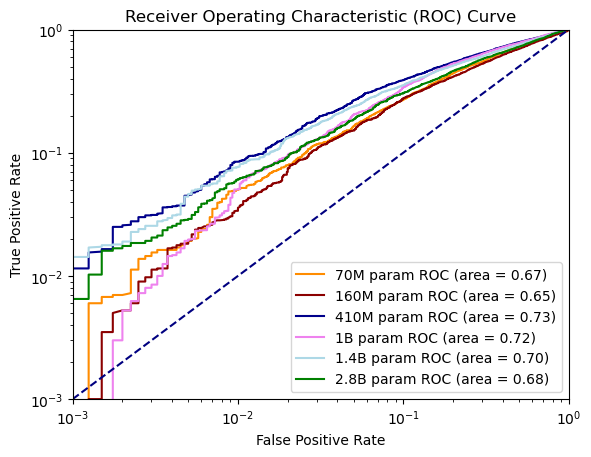

In [102]:

# Plot the ROC curve
for i in range(len(train_data)):
    plt.loglog(fpr[i], tpr[i], color=colors[i], label=names[i]+' param ROC (area = %0.2f)' % auc_res[i])
plt.plot([0.001, 1], [0.001, 1], color='navy', linestyle='--')
plt.xlim([0.001, 1])
plt.ylim([0.001, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("difference thresholding roc log scale.png")